In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import numpy as np
import seaborn as sns
from datetime import datetime
import tensorflow as tf
# import tensorflow.compat.v1.keras.backend as K 
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()

from tensorflow import keras
from tensorflow.keras import layers  # TF model
import shap as shap  # Visualizing tool
from scipy.stats import norm
from scipy import stats

In [2]:
%store -r train_features
%store -r test_features

%store -r train_labels
%store -r test_labels

The tf.keras.layers.Normalization adding a feature normalization into the model.

Create the layer

In [3]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Fit the state of the preprocessing layer to the data

In [4]:
normalizer.adapt(np.array(train_features))

2022-06-16 16:50:54.932072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/arch/Debian10/EB_production/2021/software/Qhull/2020.2-GCCcore-10.3.0/lib:/sw/arch/Debian10/EB_production/2021/software/SciPy-bundle/2021.05-foss-2021a/lib/python3.9/site-packages/numpy/core/lib:/sw/arch/Debian10/EB_production/2021/software/PyTorch/1.10.0-foss-2021a-CUDA-11.3.1/lib/python3.9/site-packages/torch/lib:/sw/arch/Debian10/EB_production/2021/software/magma/2.6.1-foss-2021a-CUDA-11.3.1/lib:/sw/arch/Debian10/EB_production/2021/software/FFmpeg/4.3.2-GCCcore-10.3.0/lib:/sw/arch/Debian10/EB_production/2021/software/FriBidi/1.0.10-GCCcore-10.3.0/lib:/sw/arch/Debian10/EB_production/2021/software/x265/3.5-GCCcore-10.3.0/lib:/sw/arch/Debian10/EB_production/2021/software/LAME/3.100-GCCcore-10.3.0/lib:/sw/arch/Debian10/EB_production/2021/software/x2

Calculating the mean and variance, and storing them in the layer:

In [5]:
print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

[[4.5719843e+00 8.5137823e+02 7.1319043e+02 5.0751388e-01 5.8288473e-01
  2.7596102e+04 2.2877213e+04]]
First example: [[   0 1373 1144    1    1  167 3748]]

Normalized: [[-0.09  1.05  0.31  0.99  0.85 -0.37 -0.18]]


# 4. Regression using a DNN and multiple inputs

The normalization layer

Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.

A linear Dense single-output layer.

Mean Absolute Error

In [6]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'), #tanh
        layers.Dense(64, activation='relu'), #tanh
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

Mean Squared Error

In [408]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [7]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


In [8]:
train_features = train_features.sample(100)
train_labels = train_labels.sample(100)

test_labels = test_labels.sample(100)
test_features = test_features.sample(100)

In [9]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [TotalVotes]')
    plt.legend()
    plt.grid(True)

Mean Absolute Error

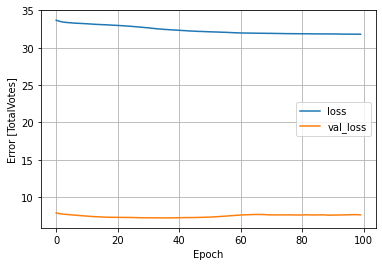

In [12]:
plot_loss(history)
plt.show()

Mean Squared Error

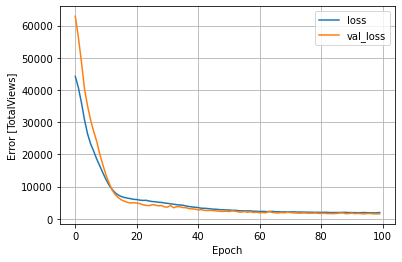

In [411]:
plot_loss(history)
plt.show()

Collect the results on the test set

Mean Absolute Error

In [12]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Mean Squared Error

In [379]:
test_results_MSE['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Shap presentation

In [13]:
dnn_model.input_shape

(None, None)

In [35]:
new_model_input = tf.keras.layers.Input(shape=(7,))
new_model_output = dnn_model(new_model_input)
new_dnn_model = tf.keras.models.Model(inputs=new_model_input, outputs=new_model_output)

In [37]:
background = shap.maskers.Independent(train_features)

In [39]:
explainer = shap.Explainer(dnn_model, background)

In [41]:
shap_values = explainer(test_features)

Exact explainer: 101it [00:43,  2.32it/s]                         


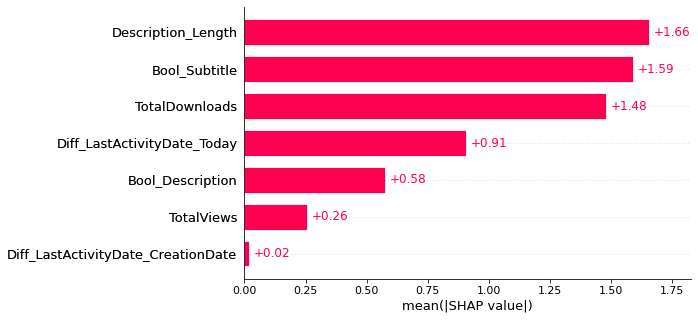

In [42]:
shap.plots.bar(shap_values, max_display=10)

In [98]:
test_predictions = dnn_model.predict(test_features).flatten()

In [19]:
pd.DataFrame(test_results, index=['Mean absolute error [TotalVotes]']).T

,Mean absolute error [TotalVotes]
dnn_model,3.276978


In [443]:
pd.DataFrame(test_results_MSE, index=['Mean squared error [TotalVotes]']).T

,Mean squared error [TotalVotes]
totalviews_model,25636.134766
linear_model,25100.847656
dnn_totalviews_model,5957.702637
dnn_model,2424.900879
xgb_model,146.553059
xgb_model_without_usage,3166.495272


In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [TotalVotes]']).T

pd.DataFrame(test_results_MSE, index=['Mean squared error [TotalVotes]']).T